In [1]:
import numpy as np
import ipywidgets as widgets
import ipycanvas as cv
import matplotlib.pyplot as plt
from IPython.display import display
import time
import threading as th
import sys

In [2]:
def make_canvas_bg(w, h, n_z=2, this_z=1):
    canvas = cv.MultiCanvas(n_z, width=w, height=h)
    canvas[this_z].line_width = 2
    canvas[this_z].stroke_rect(0, 0, w, h)

    mid = np.floor(w / 2)
    canvas[this_z].stroke_line(mid, 0, mid, h)

    text_pos_x = 10
    text_pos_y = 15
    canvas[this_z].font = "14px sans-serif" # default: 12px sans-serif
    canvas[this_z].fill_text("v=c₁", text_pos_x, text_pos_y)
    canvas[this_z].fill_text("v=c₂=2c₁", mid+text_pos_x, text_pos_y)

    t_pos_x = np.floor(0.9 * w)
    t_pos_y = np.floor(0.12 * h)
    t_size = 20

    # Zeichne einen Smiley als Detektor
    canvas[this_z].begin_path()
    canvas[this_z].arc(t_pos_x, t_pos_y, t_size, 0, np.pi * 2) # Outer circle
    # canvas[1].move_to(t_pos_x + np.floor(0.65 * t_size), t_pos_y)
    
    canvas[this_z].stroke()
    canvas[this_z].fill_style = 'white'
    canvas[this_z].fill()

    canvas[this_z].begin_path()
    canvas[this_z].arc(t_pos_x, t_pos_y, np.floor(0.65 * t_size), 0, np.pi) # Mouth (clockwise)
    canvas[this_z].move_to(t_pos_x - np.floor(0.32 * t_size) + np.floor(0.12 * t_size), t_pos_y - np.floor(0.2 * t_size))
    canvas[this_z].arc(t_pos_x - np.floor(0.32 * t_size), t_pos_y - np.floor(0.2 * t_size), np.floor(0.12 * t_size), 0, np.pi * 2) # Left eye
    canvas[this_z].move_to(t_pos_x + np.floor(0.32 * t_size) + np.floor(0.12 * t_size), t_pos_y - np.floor(0.2 * t_size))
    canvas[this_z].arc(t_pos_x + np.floor(0.32 * t_size), t_pos_y - np.floor(0.2 * t_size), np.floor(0.12 * t_size), 0, np.pi * 2) # Left eye
    canvas[this_z].stroke()

    # Zeichne einen Stern (allgemeine Zacken-Zahl)
    l_pos_x = np.floor(0.1 * w)
    l_pos_y = np.floor(0.88 * h)
    spikes = 6
    l_size = 20
    l_size_inner = np.floor(0.5 * l_size)
    rot = np.pi / 2 * 3
    x = l_pos_x
    y = l_pos_y
    step = np.pi / spikes

    canvas[this_z].begin_path()
    canvas[this_z].move_to(l_pos_x, l_pos_y - l_size)
    for i in range(spikes):
        x = l_pos_x + np.cos(rot) * l_size
        y = l_pos_y + np.sin(rot) * l_size
        canvas[this_z].line_to(x,y)
        rot += step

        x = l_pos_x + np.cos(rot) * l_size_inner
        y = l_pos_y + np.sin(rot) * l_size_inner
        canvas[this_z].line_to(x,y)
        rot += step
    
    canvas[this_z].line_to(l_pos_x, l_pos_y - l_size)
    canvas[this_z].close_path()
    canvas[this_z].line_width = 5
    canvas[this_z].stroke_style = 'orange'
    canvas[this_z].stroke()
    canvas[this_z].fill_style = 'yellow'
    canvas[this_z].fill()

    object_pos = (l_pos_x, l_pos_y, mid, t_pos_x, t_pos_y)

    return canvas, object_pos

def make_canvas_fg(canvas, alpha_deg, object_pos, this_z=0):
    # Canvas Inhalt löschen
    canvas[0].clear()

    # Eingaben auslesen
    alpha = np.pi * alpha_deg / 180

    # Lichtstrahl
    canvas[this_z].line_width = 3
    canvas[this_z].stroke_style = 'gold'
    mid_pt_y = object_pos[1] - np.tan(alpha) * (object_pos[2] - object_pos[0])
    canvas[this_z].stroke_line(object_pos[0], object_pos[1], object_pos[2], mid_pt_y)
    canvas[this_z].stroke_line(object_pos[2], mid_pt_y, object_pos[3], object_pos[4])

    # Zeit zwischen Aussenden und Empfangen
    c1 = 0.5
    c2 = 1
    ds1 = np.sqrt((object_pos[2] - object_pos[0])**2 + (object_pos[1] - mid_pt_y)**2)
    ds2 = np.sqrt((object_pos[3] - object_pos[2])**2 + (mid_pt_y - object_pos[4])**2)
    dt = (ds1 / c1) + (ds2 / c2) 
    canvas[this_z].font = "16px sans-serif" # default: 12px sans-serif
    canvas[this_z].stroke_style = 'black'
    canvas[this_z].fill_text("Δt="+str(round(dt,2)), object_pos[3] - 0.3 * (object_pos[3] - object_pos[2]), object_pos[1])

    return canvas

cvWidth = 600
cvHeigth = 400
canvas, object_pos = make_canvas_bg(w=cvWidth, h=cvHeigth)

slider = widgets.FloatSlider(min=0.0, max=55, step=1.5, value=0.0, description = "Winkel")
out = widgets.interactive(make_canvas_fg, canvas=widgets.fixed(canvas), alpha_deg=slider, object_pos=widgets.fixed(object_pos), this_z=widgets.fixed(0))
display(out)
display(out.result)

interactive(children=(FloatSlider(value=0.0, description='Winkel', max=55.0, step=1.5), Output()), _dom_classe…

MultiCanvas(height=400, width=600)

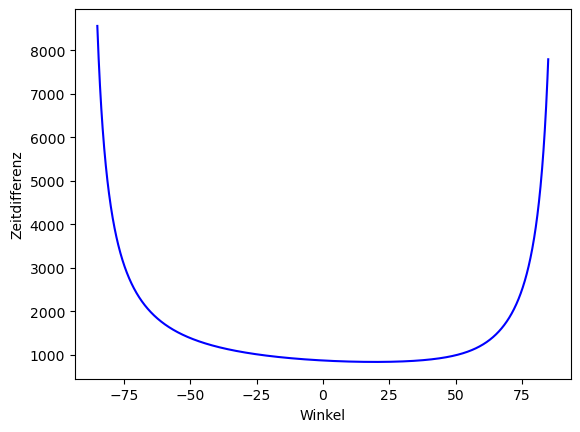

In [3]:
canvas, object_pos = make_canvas_bg(w=cvWidth, h=cvHeigth)

def light_time(alpha_deg, object_pos):
    alpha = np.pi * alpha_deg / 180
    mid_pt_y = object_pos[1] - np.tan(alpha) * (object_pos[2] - object_pos[0])

    c1 = 0.5
    c2 = 1
    ds1 = np.sqrt((object_pos[2] - object_pos[0])**2 + (object_pos[1] - mid_pt_y)**2)
    ds2 = np.sqrt((object_pos[3] - object_pos[2])**2 + (mid_pt_y - object_pos[4])**2)
    dt = (ds1 / c1) + (ds2 / c2) 
    return dt


# evenly sampled time at 200ms intervals
alphas = np.arange(-85., 85., 0.1)
plt.plot(alphas, light_time(alphas, object_pos), 'b-')
plt.xlabel("Winkel")
plt.ylabel("Zeitdifferenz")
plt.show()

In [11]:
canvas, object_pos = make_canvas_bg(w=cvWidth, h=cvHeigth)

alphas = np.arange(-85., 85., 0.1)

def light_time_c_ratio(alpha_deg, object_pos, c_ratio):
    alpha = np.pi * alpha_deg / 180
    mid_pt_y = object_pos[1] - np.tan(alpha) * (object_pos[2] - object_pos[0])

    c1 = c_ratio
    c2 = 1
    ds1 = np.sqrt((object_pos[2] - object_pos[0])**2 + (object_pos[1] - mid_pt_y)**2)
    ds2 = np.sqrt((object_pos[3] - object_pos[2])**2 + (mid_pt_y - object_pos[4])**2)
    dt = (ds1 / c1) + (ds2 / c2) 
    return dt

def plot_graph(c_ratio, alphas, object_pos, use_log_y=False):
    alphas = np.arange(-85., 85., 0.1)
    y_vals = light_time_c_ratio(alphas, object_pos, c_ratio)
    min_alpha = alphas[np.argmin(y_vals)]

    plt.plot(alphas, y_vals, 'b-')
    plt.xlabel("Winkel")
    plt.ylabel("Zeitdifferenz")
    if use_log_y == True:
        plt.ylim(500, 30000)
        plt.yscale('log')
    else:
        plt.ylim(0, 30000)
    plt.axvline(x = min_alpha, color = 'r', label = 'minimum')
    plt.show()

slider = widgets.FloatSlider(min=0.1, max=0.9, step=0.01, value=0.1, description = "Quot. c₁/c₂")
button = widgets.ToggleButton(value=False, description='y Achse lin./log.', disabled=False, icon='check')

out = widgets.interactive(plot_graph, c_ratio=slider, alphas=widgets.fixed(alphas), object_pos=widgets.fixed(object_pos), use_log_y=button)
display(out)
display(out.result)

interactive(children=(FloatSlider(value=0.1, description='Quot. c₁/c₂', max=0.9, min=0.1, step=0.01), ToggleBu…

None

In [12]:
def make_canvas_fg_reduced(canvas, alpha_deg, object_pos, this_z=1, this_z_particle=0):
    # Canvas Inhalt löschen
    canvas[this_z].clear()
    # event.clear()

    # Eingaben auslesen
    alpha = np.pi * alpha_deg / 180

    # Zeit zwischen Aussenden und Empfangen
    c1 = 0.5
    c2 = 1
    mid_pt_y = object_pos[1] - np.tan(alpha) * (object_pos[2] - object_pos[0])
    ds1 = np.sqrt((object_pos[2] - object_pos[0])**2 + (object_pos[1] - mid_pt_y)**2)
    ds2 = np.sqrt((object_pos[3] - object_pos[2])**2 + (mid_pt_y - object_pos[4])**2)
    dt = (ds1 / c1) + (ds2 / c2) 
    canvas[this_z].font = "16px sans-serif" # default: 12px sans-serif
    canvas[this_z].stroke_style = 'black'
    canvas[this_z].fill_text("Δt="+str(round(dt,2)), object_pos[3] - 0.3 * (object_pos[3] - object_pos[2]), object_pos[1])

    # Terminate all other threads, die alte Simulations-Schleife
    for thread in th.enumerate():
        if thread.name == 'canvasParticles':
            thread.stop()
            thread.join()

    # Start the loop
    thread = canvasParticles(canvas, alpha, object_pos, this_z_particle)
    thread.name = 'canvasParticles'
    thread.start()
    # thread.join()

    return canvas

class canvasParticles(th.Thread):
    def __init__(self, canvas, alpha, object_pos, this_z):
        # global event
        # event.set()
        self.canvas = canvas
        self.object_pos = object_pos
        self.this_z = this_z
        super(canvasParticles, self).__init__()
        self.speed_1 = 2
        self.speed_2 = 4

        n_points = 1000
        self.normal_std = 3

        x_val = np.random.uniform(self.object_pos[0], self.object_pos[3], n_points)
        x_val.sort()
        mid_pt_y = self.object_pos[1] - np.tan(alpha) * (self.object_pos[2] - self.object_pos[0])
        self.slope_1 = (mid_pt_y - self.object_pos[1]) / (self.object_pos[2] - self.object_pos[0])
        self.off_1 = mid_pt_y - self.slope_1 * object_pos[2]
        self.slope_2 = (self.object_pos[4] - mid_pt_y) / (self.object_pos[3] - self.object_pos[2])
        self.off_2 = self.object_pos[4] - self.slope_2 * self.object_pos[3]
        x_val_split_pos = np.argmax(x_val > self.object_pos[2])
        self.x_val_1 = x_val[0:x_val_split_pos]
        self.x_val_2 = x_val[x_val_split_pos:]

        self.y_val_1 = self.slope_1 * self.x_val_1 + self.off_1
        self.y_val_2 = self.slope_2 * self.x_val_2 + self.off_2

        self.y_val_1 += np.random.normal(loc=0.0, scale=self.normal_std, size=self.y_val_1.size)
        self.y_val_2 += np.random.normal(loc=0.0, scale=self.normal_std, size=self.y_val_2.size)

        self.speed_1_x = self.speed_1 / np.sqrt(1.0 + self.slope_1**2)
        self.speed_2_x = self.speed_2 / np.sqrt(1.0 + self.slope_2**2)

        self.cmap = plt.get_cmap('Spectral')
        self.colors_1 = np.squeeze(self.cmap(np.random.randint(0, 255, size=(self.x_val_1.size, 1))), axis=1)
        self.colors_2 = np.squeeze(self.cmap(np.random.randint(0, 255, size=(self.x_val_2.size, 1))), axis=1)
        self.colors_1 = self.colors_1[:, 0:3] * 255
        self.colors_2 = self.colors_2[:, 0:3] * 255

        self._stop_event = th.Event()

    def stop(self):
        self._stop_event.set()

    def update_photons(self):
        # Move points
        self.x_val_1 += self.speed_1_x
        self.x_val_2 += self.speed_2_x

        # Check division into old and new
        move_ind_1 = np.argmax(self.x_val_1 > self.object_pos[2])
        n_move = self.x_val_1.size - move_ind_1
        if move_ind_1 > 0: # nur, falls die Bedingung erfüllt werden kann
            self.x_val_2 = np.insert(self.x_val_2, 0, self.x_val_1[move_ind_1:])
            self.y_val_2 = np.insert(self.y_val_2, 0, self.y_val_1[move_ind_1:])
            self.colors_2 = np.insert(self.colors_2, 0, self.colors_1[move_ind_1:, :], axis=0)
            self.x_val_1 = np.delete(self.x_val_1, range(move_ind_1, self.x_val_1.size))
            self.y_val_1 = np.delete(self.y_val_1, range(move_ind_1, self.y_val_1.size))
            self.colors_1 = np.delete(self.colors_1, range(move_ind_1, self.colors_1.shape[0]), axis=0)

        del_ind_2 = np.argmax(self.x_val_2 > self.object_pos[3])
        if del_ind_2 > 0: # nur, falls die Bedingung erfüllt werden kann
            self.x_val_2 = np.delete(self.x_val_2, range(del_ind_2, self.x_val_2.size))
            self.y_val_2 = np.delete(self.y_val_2, range(del_ind_2, self.y_val_2.size))
            self.colors_2 = np.delete(self.colors_2, range(del_ind_2, self.x_val_2.shape[0]), axis=0)

        # Update y values
        self.y_val_1 += self.speed_1_x * self.slope_1
        self.y_val_2 += self.speed_2_x * self.slope_2

        # Add new y values
        if move_ind_1 > 0: # nur, falls die Bedingung erfüllt werden kann
            x_val_new = np.random.uniform(self.object_pos[0], self.object_pos[0] + self.speed_1, n_move)
            x_val_new.sort()
            y_val_new = self.slope_1 * x_val_new + self.off_1
            y_val_new += np.random.normal(loc=0.0, scale=self.normal_std, size=y_val_new.size)
            colors_new = np.squeeze(self.cmap(np.random.randint(0, 255, size=(n_move, 1))), axis=1)
            colors_new = colors_new[:, 0:3] * 255

            self.x_val_1 = np.insert(self.x_val_1, 0, x_val_new)
            self.y_val_1 = np.insert(self.y_val_1, 0, y_val_new)
            self.colors_1 = np.insert(self.colors_1, 0, colors_new, axis=0)

    def draw(self):
        # self.canvas[self.this_z].fill_style = "green"
        # self.canvas[self.this_z].fill_rects(self.x_val_1, self.y_val_1, 3)
        # self.canvas[self.this_z].fill_rects(self.x_val_2, self.y_val_2, 3)

        self.canvas[self.this_z].fill_styled_rects(self.x_val_1, self.y_val_1, 3, 3, self.colors_1, 0.7)
        self.canvas[self.this_z].fill_styled_rects(self.x_val_2, self.y_val_2, 3, 3, self.colors_2, 0.7)

    def run(self):
        while True:
            with cv.hold_canvas():
                self.update_photons()
                self.canvas[self.this_z].clear()
                self.draw()

            if self._stop_event.is_set():
                sys.exit()

            time.sleep(0.05) # Animation frequency ~50Hz = 1./50. seconds

cvWidth = 600
cvHeigth = 400
canvas, object_pos = make_canvas_bg(w=cvWidth, h=cvHeigth, n_z=3, this_z=2)

slider = widgets.FloatSlider(min=0.0, max=55, step=1.5, value=0.0, description = "Winkel")
out = widgets.interactive(make_canvas_fg_reduced, canvas=widgets.fixed(canvas), alpha_deg=slider, object_pos=widgets.fixed(object_pos), this_z=widgets.fixed(1), this_z_particle=widgets.fixed(0))
display(out)
display(out.result)


interactive(children=(FloatSlider(value=0.0, description='Winkel', max=55.0, step=1.5), Output()), _dom_classe…

MultiCanvas(height=400, width=600)